In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

# На изображении

(960, 640, 3)

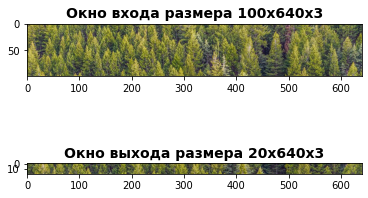

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

image = plt.imread('rgb_image.jpg') / 255.0

def truncate(x, train_len=100, test_len=20):
    in_, out_ = [], []
    for i in range(len(x)-train_len-test_len+1):
        in_.append(x[i:(i+train_len), :, :])
        out_.append(x[(i+train_len):(i+train_len+test_len), :, :])
    return np.array(in_), np.array(out_)

X_in, X_out = truncate(image, test_len=20)

fig,axs=plt.subplots(2,1)
axs[0].imshow(X_in[0])
axs[0].set_title('Окно входа размера 100x640x3', fontsize=14, fontweight='bold')
axs[1].imshow(X_out[0])
axs[1].set_title('Окно выхода размера 20x640x3', fontsize=14, fontweight='bold')

image.shape

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Reshape, Conv3D, ConvLSTM2D, Conv3DTranspose

In [ ]:
X_in.shape, X_out.shape

((841, 100, 640, 3), (841, 20, 640, 3))

In [ ]:
windows_num = 5
output_shape = X_out.shape

def seq2seq(input_shape, output_shape):

  # энкодер
  encoder_input = Input(shape=input_shape[1:])
  windows_num = input_shape[1]//output_shape[1]
  encoder_reshape = Reshape((
      # ConvLSTM2D input shape == (batch_size, num_frames, width, height, channels)
      windows_num, output_shape[1], output_shape[2], output_shape[3]))(encoder_input)

  encoder_input_conv = Conv3D(
      28,
      (1, 10, 10),
      # strides=(1, 2, 2),
      data_format='channels_last',
      activation='relu',
      padding='same'
  )(encoder_reshape)
  encoder_lstm1, state_h1, state_c1 = ConvLSTM2D(
      filters=14,
      kernel_size=(5, 5),
      padding='same',
      activation='relu',
      data_format='channels_last',
      return_sequences=True,
      return_state=True
  )(encoder_input_conv)

  ##############################################################################
  # декодер
  forcaster_input = Input(shape=(output_shape[1], output_shape[2], output_shape[3]))
  forcaster_reshape = Reshape((
      # ConvLSTM2D input shape == (batch_size, num_frames, width, height, channels)
      1, output_shape[1], output_shape[2], output_shape[3]))(forcaster_input)

  forcaster_lstm1 = ConvLSTM2D(
      filters=14,
      kernel_size=(5, 5),
      padding='same',
      activation='relu',
      data_format='channels_last',
      return_sequences=True,
      return_state=False,
  )
  forcaster_lstm1 = forcaster_lstm1(forcaster_reshape, initial_state=[state_h1, state_c1])

  forcaster_conv1 = Conv3DTranspose(
      28,
      (1, 10, 10),
      # strides=(1, 2, 2),
      data_format='channels_last',
      activation='relu',
      padding='same'
  )(forcaster_lstm1)

  forcaster_decoded = Conv3D(
      3,
      (1, 1, 1),
      padding='same',
      data_format='channels_last',
      activation='linear'
  )(forcaster_conv1)

  output = Reshape(output_shape[1:])(forcaster_decoded)

  model = Model([encoder_input, forcaster_input], output)
  model.build(input_shape=input_shape)
  return model

model = seq2seq(X_in.shape, X_out.shape)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 640, 3  0           []                               
                                )]                                                                
                                                                                                  
 reshape (Reshape)              (None, 5, 20, 640,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 20, 640, 3)  0           []                               
                                ]                                                             

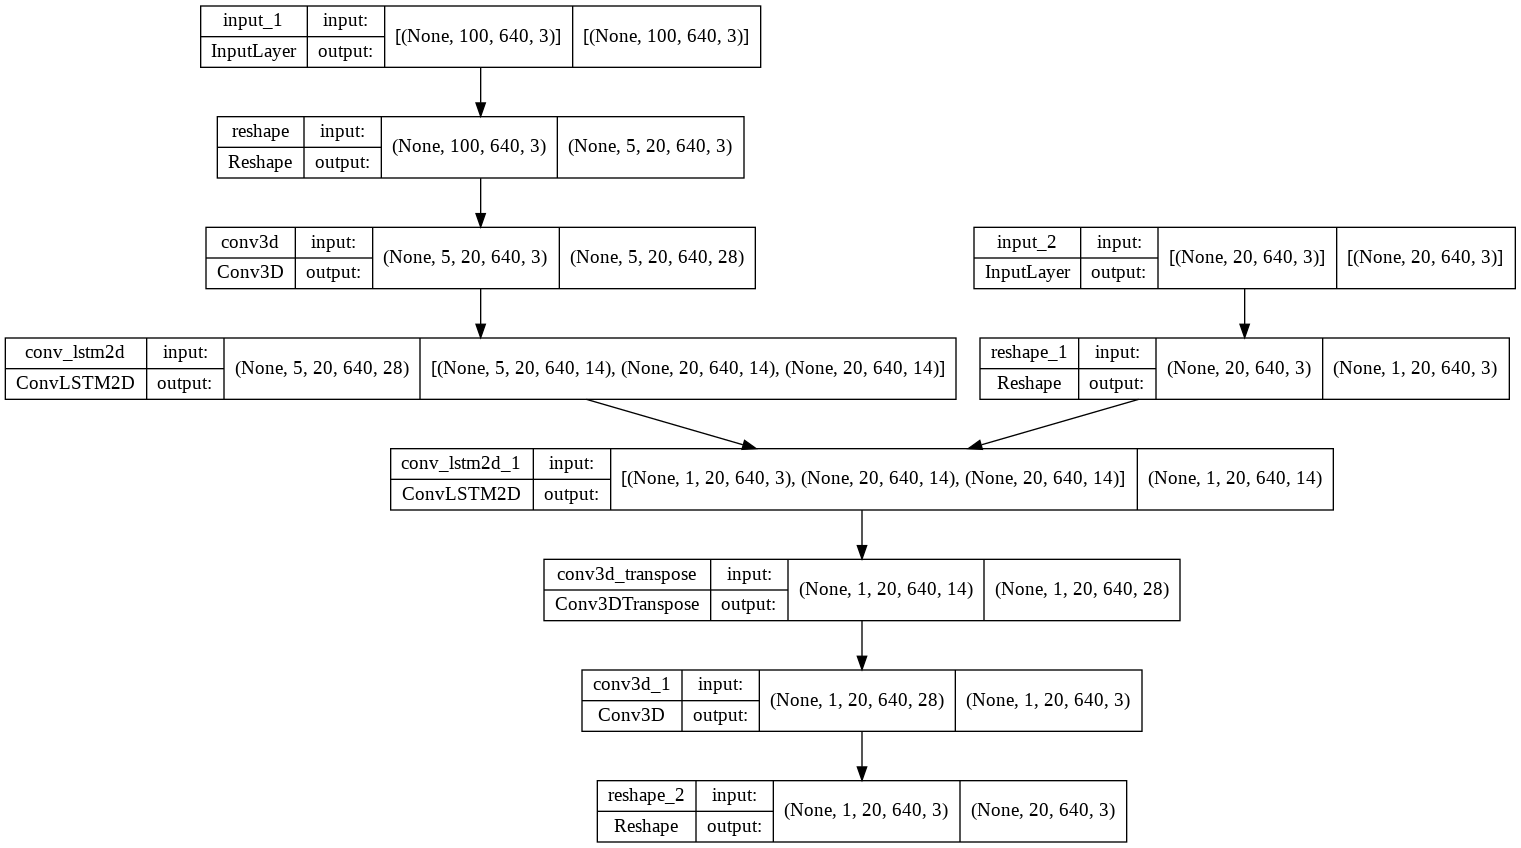

In [ ]:
tf.keras.utils.plot_model(model,show_shapes=True)

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=0.0001,
        beta_1=0.5,
        beta_2=0.999,), loss='mae')
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
history = model.fit([X_in, np.zeros_like(X_out)], X_out, epochs=20, callbacks=callback, validation_split=0.2)

Epoch 1/20
21/21 [==============================] - 31s 796ms/step - loss: 0.1950 - val_loss: 0.1241
Epoch 2/20
21/21 [==============================] - 15s 740ms/step - loss: 0.1153 - val_loss: 0.1178
Epoch 3/20
21/21 [==============================] - 16s 746ms/step - loss: 0.1088 - val_loss: 0.1139
Epoch 4/20
21/21 [==============================] - 16s 752ms/step - loss: 0.1056 - val_loss: 0.1094
Epoch 5/20
21/21 [==============================] - 16s 758ms/step - loss: 0.1039 - val_loss: 0.1104
Epoch 6/20
21/21 [==============================] - 16s 756ms/step - loss: 0.1028 - val_loss: 0.1080
Epoch 7/20
21/21 [==============================] - 16s 754ms/step - loss: 0.1015 - val_loss: 0.1065
Epoch 8/20
21/21 [==============================] - 16s 751ms/step - loss: 0.1007 - val_loss: 0.1089
Epoch 9/20
21/21 [==============================] - 16s 754ms/step - loss: 0.1000 - val_loss: 0.1051
Epoch 10/20
21/21 [==============================] - 16s 755ms/step - loss: 0.0995 - val_lo

Text(0, 0.5, 'MAE')

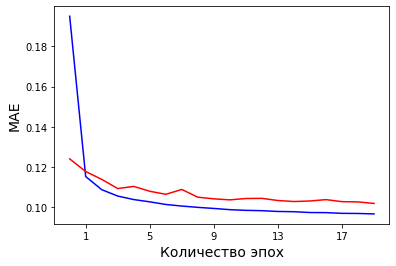

In [ ]:
plt.plot(history.history['loss'], label='MAE (training data)', c='b')
plt.plot(history.history['val_loss'], label='MAE (validation data)', c='r')
plt.xticks([i for i in range(1, 21, 4)])
plt.xlabel('Количество эпох', fontsize=14)
plt.ylabel('MAE', fontsize=14)

In [ ]:
pred = model.predict([X_in, np.zeros_like(X_out)])

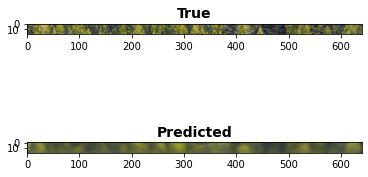

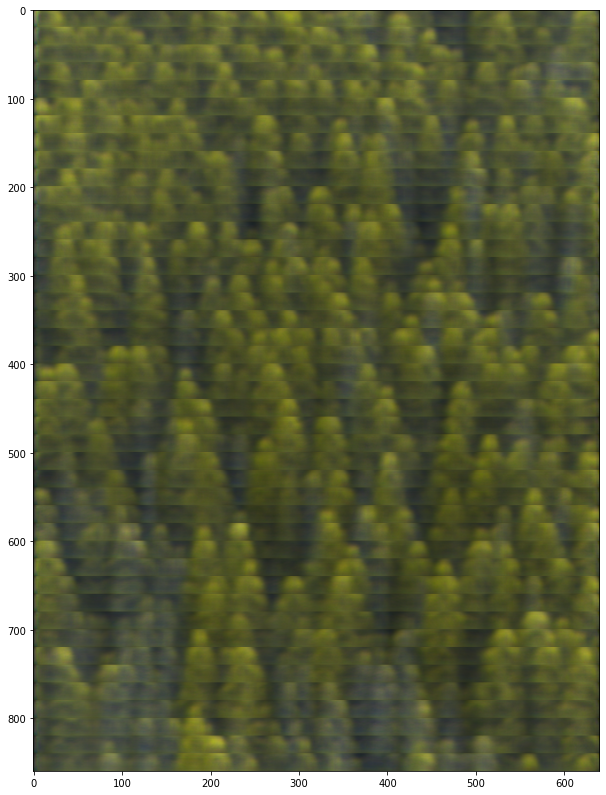

In [ ]:
fig,axs=plt.subplots(2,1)

axs[0].imshow(X_out[0])
axs[0].set_title('True', fontsize=14, fontweight='bold')
axs[1].imshow(pred[0])
axs[1].set_title('Predicted', fontsize=14, fontweight='bold')
plt.show()

plt.figure(figsize=(12, 14))
plt.imshow(pred[::20].reshape(43*20, 640, 3))

# Подготовка датасета

In [ ]:
!pip install pydarn

In [ ]:
import pydarn
import numpy as np

def get_timeseries(data, key, bmnum, channel, mask_key='qflg'):
  timeseries = []
  nrang = data[0]['nrang'] # количество точек
  for i in range(len(data)):
    if data[i]['bmnum'] == bmnum and data[i]['channel'] == channel:
      if 'slist' in data[i]:
        line = np.zeros(nrang) # * np.nan # 0 * np.nan == nan
        mask = np.zeros(nrang)
        for n, m in enumerate(data[i]['slist']):
          line[m] = data[i][key][n]
          mask[m] = data[i][mask_key][n]
        line = np.multiply(line, mask)
        timeseries.append(line)
  return np.rot90(np.array(timeseries), k=1)

def get_dataset(data, keys, bmnum, channel, mask_key='qflg'):
  dataset = []
  for key in keys:
    dataset.append(get_timeseries(data, key, bmnum, channel))
  return np.array(dataset).T

def truncate(x, window_size=20, in_len=4, out_len=1):
    in_, out_ = [], []
    for i in range(len(x)-in_len*window_size-out_len*window_size+1):
        in_.append(x[i:(i+in_len*window_size), :, :])
        out_.append(x[(i+in_len*window_size):(i+in_len*window_size+out_len*window_size), :, :])
    return np.array(in_), np.array(out_)

In [ ]:
from datetime import datetime, timedelta, time

def daterange(start_date, end_date):
  for n in range(int((end_date - start_date).days)):
    yield start_date + timedelta(n)

import requests

start_date = datetime(2022, 3, 1, 0, 0, 0)
end_date = datetime(2022, 4, 1, 0, 0, 0)
for single_date in daterange(start_date, end_date):
  year, month, day = single_date.strftime("%Y %m %d").split()
  for h in range(0, 24, 2):
      m=0
    # for m in range(0, 5):
      hm = time(h, m).strftime("%H%M")
      url = f'https://chapman.usask.ca/data/{year}/{month}/{year}{month}{day}.{hm}.00.inv.a.fitacf.bz2'
      r = requests.get(url, allow_redirects=True)
      if r.status_code == 200:
        filename = f'{year}{month}{day}.{hm}.00.inv.a.fitacf.bz2'
        print(filename)
        f = open(filename, 'wb')
        f.write(r.content)
        f.close()

20220301.0200.00.inv.a.fitacf.bz2
20220301.0400.00.inv.a.fitacf.bz2
20220301.0600.00.inv.a.fitacf.bz2
20220301.0800.00.inv.a.fitacf.bz2
20220301.1000.00.inv.a.fitacf.bz2
20220301.1200.00.inv.a.fitacf.bz2
20220301.1400.00.inv.a.fitacf.bz2
20220301.1600.00.inv.a.fitacf.bz2
20220301.1800.00.inv.a.fitacf.bz2
20220301.2000.00.inv.a.fitacf.bz2
20220301.2200.00.inv.a.fitacf.bz2
20220302.0000.00.inv.a.fitacf.bz2
20220302.0200.00.inv.a.fitacf.bz2
20220302.0400.00.inv.a.fitacf.bz2
20220302.0600.00.inv.a.fitacf.bz2
20220302.0800.00.inv.a.fitacf.bz2
20220302.1000.00.inv.a.fitacf.bz2
20220302.1200.00.inv.a.fitacf.bz2
20220302.1400.00.inv.a.fitacf.bz2
20220302.1600.00.inv.a.fitacf.bz2
20220302.1800.00.inv.a.fitacf.bz2
20220302.2000.00.inv.a.fitacf.bz2
20220302.2200.00.inv.a.fitacf.bz2
20220303.0000.00.inv.a.fitacf.bz2
20220303.0200.00.inv.a.fitacf.bz2
20220303.0400.00.inv.a.fitacf.bz2
20220303.0600.00.inv.a.fitacf.bz2
20220303.0800.00.inv.a.fitacf.bz2
20220303.1000.00.inv.a.fitacf.bz2
20220303.1200.

In [ ]:
import os
import bz2
import numpy as np

files = os.listdir()

keys = ['pwr0', 'p_l', 'p_s', 'v', 'w_l', 'w_s', 'elv']

dataset = [[], []]

for fitacf_file in files:
  if fitacf_file.endswith("fitacf.bz2"):
    with bz2.open(fitacf_file) as fp:
        fitacf_stream = fp.read()
    reader = pydarn.SuperDARNRead(fitacf_stream, True)
    records = reader.read_fitacf()
    X_in, X_out = truncate(get_dataset(records, keys, 0, 0))
    dataset[0].extend(X_in)
    dataset[1].extend(X_out)

dataset[0] = np.array(dataset[0])
dataset[1] = np.array(dataset[1])

# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(dataset[0], dataset[1], test_size=0.33, random_state=42)

# ConvRNN based sequence-to-sequence

In [ ]:
dataset[0].shape, dataset[1].shape

((8252, 80, 75, 7), (8252, 20, 75, 7))

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(dataset[0], dataset[1], test_size=0.2, random_state=74)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Reshape, Conv3D, ConvLSTM2D, Conv3DTranspose

In [ ]:
def seq2seq(input_shape, output_shape):

  # энкодер
  encoder_input = Input(shape=input_shape[1:])
  windows_num = input_shape[1]//output_shape[1]
  encoder_reshape = Reshape((
      # ConvLSTM2D input shape == (batch_size, num_frames, width, height, channels)
      windows_num, output_shape[1], output_shape[2], output_shape[3]))(encoder_input)

  encoder_input_conv = Conv3D(
      28,
      (1, 10, 10),
      # strides=(1, 2, 2),
      data_format='channels_last',
      activation='relu',
      padding='same'
  )(encoder_reshape)
  encoder_lstm1, state_h1, state_c1 = ConvLSTM2D(
      filters=14,
      kernel_size=(5, 5),
      padding='same',
      activation='relu',
      data_format='channels_last',
      return_sequences=True,
      return_state=True
  )(encoder_input_conv)

  ##############################################################################
  # декодер
  forcaster_input = Input(shape=(output_shape[1], output_shape[2], output_shape[3]))
  forcaster_reshape = Reshape((
      # ConvLSTM2D input shape == (batch_size, num_frames, width, height, channels)
      1, output_shape[1], output_shape[2], output_shape[3]))(forcaster_input)

  forcaster_lstm1 = ConvLSTM2D(
      filters=14,
      kernel_size=(5, 5),
      padding='same',
      activation='relu',
      data_format='channels_last',
      return_sequences=True,
      return_state=False,
  )
  forcaster_lstm1 = forcaster_lstm1(forcaster_reshape, initial_state=[state_h1, state_c1])

  forcaster_conv1 = Conv3DTranspose(
      28,
      (1, 10, 10),
      # strides=(1, 2, 2),
      data_format='channels_last',
      activation='relu',
      padding='same'
  )(forcaster_lstm1)

  forcaster_decoded = Conv3D(
      7,
      (1, 1, 1),
      padding='same',
      data_format='channels_last',
      activation='linear'
  )(forcaster_conv1)

  output = Reshape(output_shape[1:])(forcaster_decoded)

  model = Model([encoder_input, forcaster_input], output)
  model.build(input_shape=input_shape)
  return model

model = seq2seq(dataset[0].shape, dataset[1].shape)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 80, 75, 7)]  0           []                               
                                                                                                  
 reshape_3 (Reshape)            (None, 4, 20, 75, 7  0           ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 input_4 (InputLayer)           [(None, 20, 75, 7)]  0           []                               
                                                                                                  
 conv3d_2 (Conv3D)              (None, 4, 20, 75, 2  19628       ['reshape_3[0][0]']        

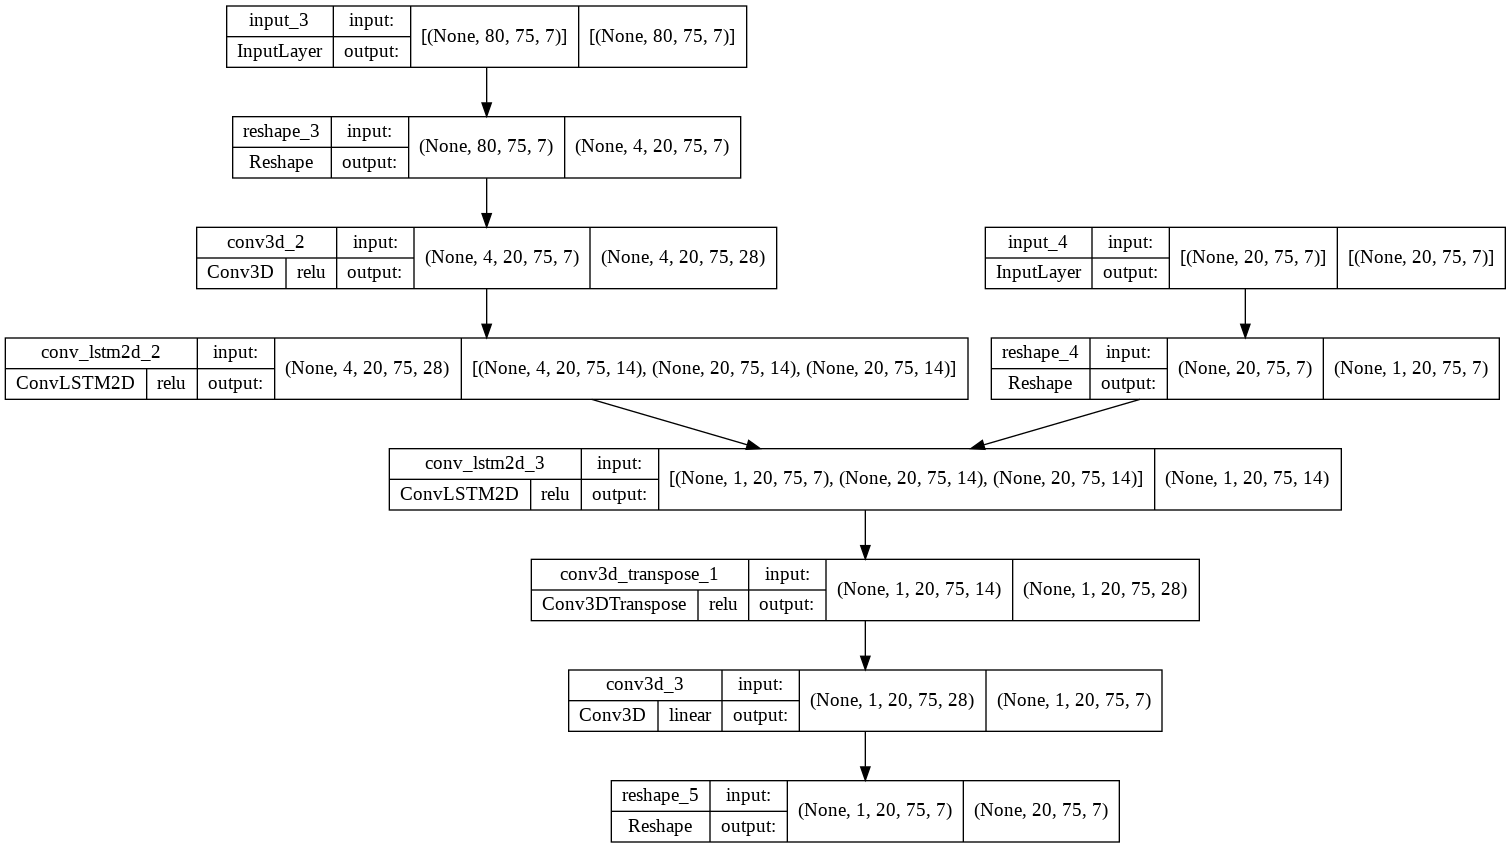

In [ ]:
tf.keras.utils.plot_model(model,
    show_shapes=True,
    show_layer_activations=True)

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=0.0001,
        beta_1=0.5,
        beta_2=0.999,), loss='mae', metrics=['mse', 'mae'])
callback = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=5)
history = model.fit([X_train, np.zeros_like(y_train)], y_train, epochs=200, callbacks=callback, validation_split=0.2)

Epoch 1/200
165/165 [==============================] - 33s 112ms/step - loss: 23.9772 - mse: 6730.7441 - mae: 23.9772 - val_loss: 22.3040 - val_mse: 6264.6846 - val_mae: 22.3040
Epoch 2/200
165/165 [==============================] - 16s 95ms/step - loss: 21.9246 - mse: 6016.6484 - mae: 21.9246 - val_loss: 21.8387 - val_mse: 6154.3882 - val_mae: 21.8387
Epoch 3/200
165/165 [==============================] - 16s 95ms/step - loss: 21.5934 - mse: 5931.3887 - mae: 21.5934 - val_loss: 21.5784 - val_mse: 6017.1240 - val_mae: 21.5784
Epoch 4/200
165/165 [==============================] - 16s 96ms/step - loss: 21.4235 - mse: 5880.4282 - mae: 21.4235 - val_loss: 21.5005 - val_mse: 5941.3838 - val_mae: 21.5005
Epoch 5/200
165/165 [==============================] - 16s 96ms/step - loss: 21.3193 - mse: 5834.0020 - mae: 21.3192 - val_loss: 21.4159 - val_mse: 5997.2520 - val_mae: 21.4159
Epoch 6/200
165/165 [==============================] - 16s 96ms/step - loss: 21.2048 - mse: 5755.3228 - mae: 21.20

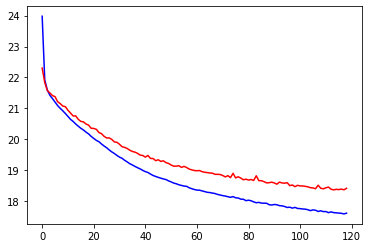

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['mae'], label='MAE (training data)', c='b')
plt.plot(history.history['val_mae'], label='MAE (validation data)', c='r')

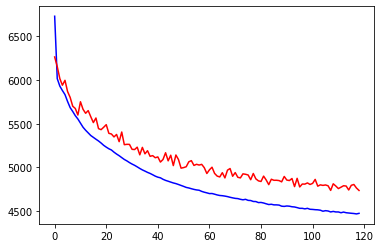

In [ ]:
plt.plot(history.history['mse'], label='MSE (training data)', c='b')
plt.plot(history.history['val_mse'], label='MSE (validation data)', c='r')

In [ ]:
model.save('my_model')

INFO:tensorflow:Assets written to: my_model/assets


In [ ]:
!tar -cvf archive.tar.gz /content/my_model

tar: Removing leading `/' from member names
/content/my_model/
/content/my_model/assets/
/content/my_model/variables/
/content/my_model/variables/variables.index
/content/my_model/variables/variables.data-00000-of-00001
/content/my_model/keras_metadata.pb
/content/my_model/saved_model.pb


In [ ]:
model.evaluate([X_test, np.zeros_like(y_test)], y_test, verbose=1)

In [ ]:
pred = model.predict([X_test, np.zeros_like(y_test)])

In [ ]:
pred.shape

(1268, 20, 75, 7)

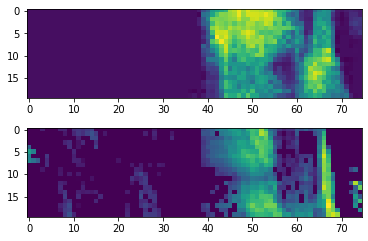

In [ ]:
import matplotlib.pyplot as pp

fig,axs=pp.subplots(2,1)
axs[0].imshow(pred[100][:,:,1])
axs[1].imshow(y_test[100][:,:,1])

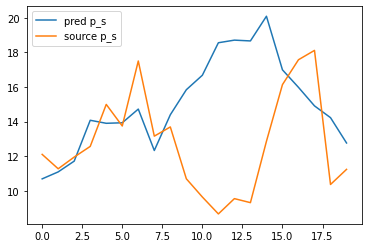

In [ ]:
import matplotlib.pyplot as pp
#print('shape:',pred[100].shape)
#print('res:',pred[100][:,50,:])
z=2
gate=65
pp.plot(pred[100][:,gate,z],label='pred '+keys[z])
pp.plot(y_test[100][:,gate,z],label='source '+keys[z])
pp.legend();


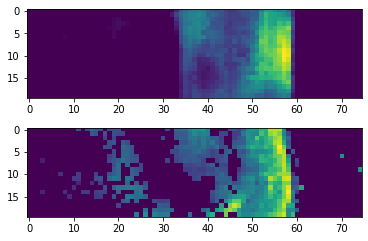

In [ ]:
fig,axs=pp.subplots(2,1)
axs[0].imshow(pred[10][:,:,2])
axs[1].imshow(y_test[10][:,:,2])

# Загрузка модели

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Reshape, Conv3D, ConvLSTM2D, Conv3DTranspose

In [ ]:
!tar -xvf archive.tar.gz

content/my_model/
content/my_model/keras_metadata.pb
content/my_model/assets/
content/my_model/variables/
content/my_model/variables/variables.data-00000-of-00001
content/my_model/variables/variables.index
content/my_model/saved_model.pb


In [ ]:
model = tf.keras.models.load_model('content/my_model')

In [ ]:
model.evaluate([dataset[0], np.zeros_like(dataset[1])], dataset[1], verbose=1)

84/84 [==============================] - 146s 2s/step - loss: 19.8564 - mse: 4620.9292 - mae: 19.8564


[19.85636329650879, 4620.92919921875, 19.856365203857422]

In [ ]:
pred = model.predict([dataset[0], np.zeros_like(dataset[1])])

In [ ]:
dataset[1].shape, pred.shape

((2663, 20, 75, 7), (2663, 20, 75, 7))

In [ ]:
m = tf.keras.metrics.MeanSquaredError()
for i in range(7):
  m.update_state(
      dataset[1][::20,:,:,i].reshape(-1, 75, 1),
      pred[::20,:,:,i].reshape(-1, 75, 1),
  )
  print(m.result().numpy())

189.75711
117.55465
93.05742
4736.5913
4634.53
5324.3896
4573.743


In [ ]:
m = tf.keras.metrics.MeanAbsoluteError()
for i in range(7):
  m.update_state(
      dataset[1][::20,:,:,i].reshape(-1, 75, 1),
      pred[::20,:,:,i].reshape(-1, 75, 1),
  )
  print(m.result().numpy())

5.987423
4.578131
4.089886
15.840938
18.275063
22.273102
19.655489


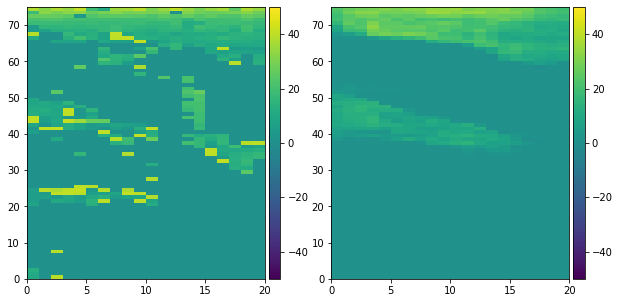

In [ ]:
import matplotlib.pyplot as pp
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable

z1 = dataset[1][140,:,:,6]
z2 = pred[140,:,:,6]

norm = mpl.colors.Normalize(vmin=-50, vmax=50)

fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
im1 = ax1.pcolormesh(z1.T, norm=norm)

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')

ax2 = fig.add_subplot(122)
im2 = ax2.pcolormesh(z2.T, norm = norm)

divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical');

# fig,axs=pp.subplots(2,1)
# axs[0].imshow(dataset[1][10,:,:,0])
# axs[0].colorbar()
# axs[1].imshow(pred[10, :,:,0])

In [ ]:
myfuckingdata = np.copy(dataset[1][0,:,:,4])

In [ ]:
myfuckingdata.min(), type(myfuckingdata)

(-0.28892672061920166, numpy.ndarray)

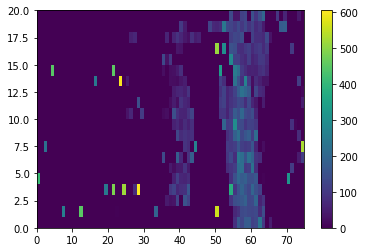

In [ ]:
minabs = abs(myfuckingdata.min()) + 1
myfuckingdata += minabs
myfuckingdata[myfuckingdata == minabs] = 0

plt.pcolormesh(myfuckingdata)
plt.colorbar()